<a href="https://colab.research.google.com/github/xeqoir/Data-Science/blob/main/Unit5/YaleXie_U5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part I: Introduction**

For my Unit 5 project, I will be using a **linear model** to predict **penguin flipper length from penguin body mass**. Specifically, I will be modelling these traits for three species of penguins: Adelie, Chinstrap, and Gentoo.

Let's get started.

P.S. I initially was trying to model stock prices with factors like interest rate, gold prices, and other stock prices. However, none of these could be generalized using a linear model (probably because they weren't sufficiently related). I ended up choosing the penguins data set after essentially giving up on stock prices and looking through Mr. Arredondo's datasets on his GitHub. Thanks, Mr. Arredondo.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# **Part II: Data**

Like I mentioned in the postscript, the data I will be using comes from Mr. Arredondo's GitHub. Let's upload the data as a **csv file** now.

In [2]:
penguins = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv', dtype={'species':'category'})
# The "dtype" thing at the end just turns species into a category column, which will be important later

In [3]:
print(penguins[['body_mass', 'flipper_length']].isna().sum())

body_mass         2
flipper_length    2
dtype: int64


In [4]:
penguins = penguins.dropna(subset=['body_mass', 'flipper_length'])
# Remove empty rows

In [5]:
penguins.reset_index(drop=True, inplace=True)
# Reindex the data frame so as not to skip indexes

In [6]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
4,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
337,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
338,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
339,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
340,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


Text(0, 0.5, 'Flipper Length')

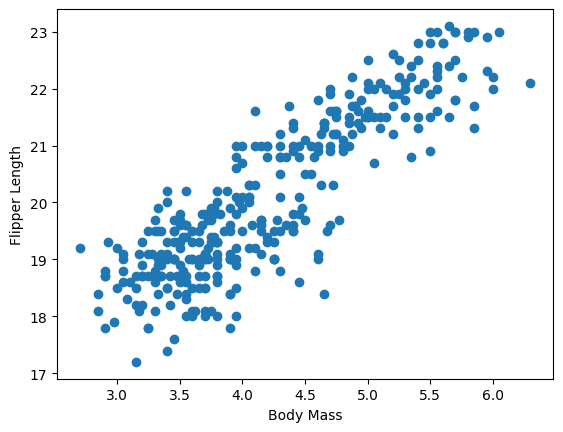

In [7]:
# Scatter plot
plt.scatter(penguins['body_mass'] , penguins['flipper_length'])

# Label axes
plt.xlabel("Body Mass")
plt.ylabel("Flipper Length")

This scatterplot shows that there seems to be a **linear relationship** between body mass and flipper length. Let's proceed by separating the data by **species**.

In [8]:
species_idx = penguins.species.cat.codes.values

species_codes = penguins.species.cat.categories

pg_coords = {"species":species_codes}

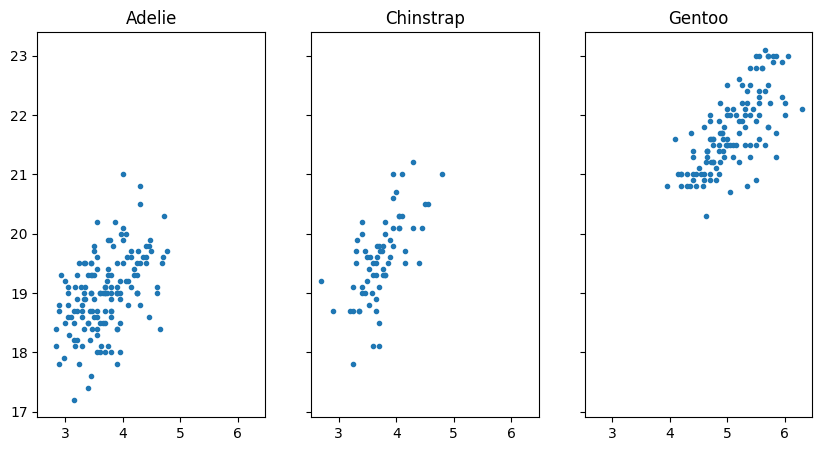

In [9]:
# Set up 3 plots for 3 species
_, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

# Make a scatter plot for each position
for i, p in enumerate(species_codes):
    ax[i].scatter(
        x = penguins.query('species == @p')['body_mass'],
        y =  penguins.query('species == @p')['flipper_length'],
        marker=".")
    ax[i].set_title(f"{p}")

The above scatterplot shows the body mass vs flipper length scatterplot for Adelie, Chinstrap, and Gentoo respectively. Each seems to have a general **upwards linear trend**, which means we are good to proceed.

# **Part III: Linear Model**

In [10]:
with pm.Model(coords={"species": species_codes}) as nh_model:
    # Priors
    α = pm.Normal("α", mu=0, sigma=3, dims="species")  # Intercept for each species
    β = pm.Normal("β", mu=0, sigma=10, dims="species") # Slope for each species
    σ = pm.HalfNormal("σ", 1)                          # Noise standard deviation

    # Linear
    mu = α[species_idx] + β[species_idx] * penguins['body_mass']

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=σ, observed=penguins['flipper_length'])

    # Sampling
    idata_nh = pm.sample(init="jitter+adapt_diag", tune=2000, return_inferencedata=True)

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


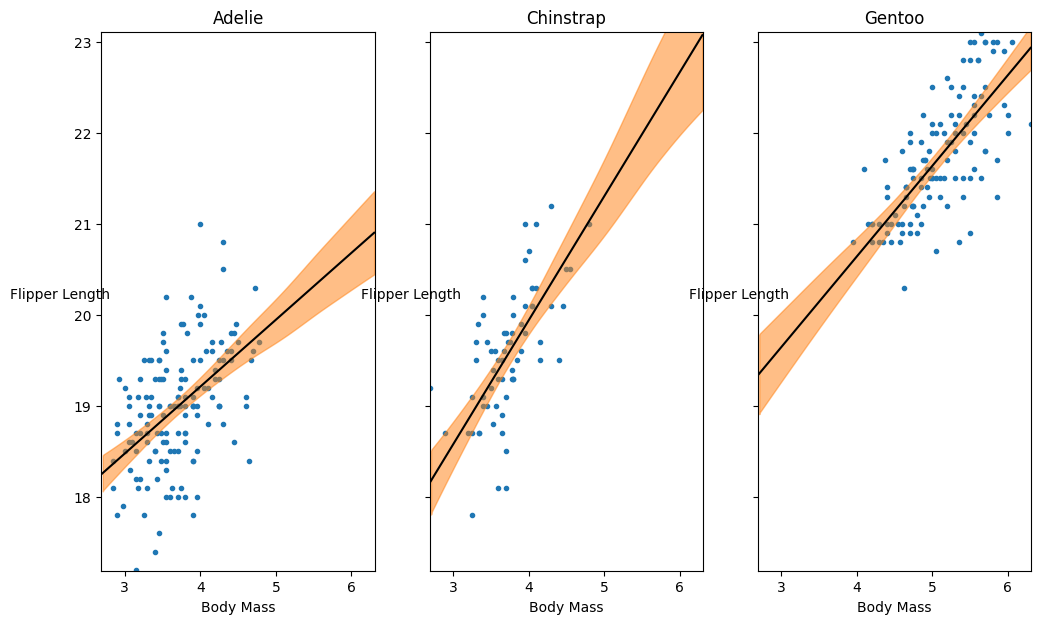

In [11]:
# Set up 3 plots for 3 species
_, ax = plt.subplots(1, 3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

# Set up x values
x_range = np.linspace(penguins['body_mass'].min(), penguins['body_mass'].max(), 10)

# Grab posterior info
posterior = az.extract(idata_nh)

# For each position
for i, p in enumerate(species_codes):
    # Plot the raw data
    ax[i].scatter(
        x = penguins.query('species == @p')['body_mass'],
        y = penguins.query('species == @p')['flipper_length'],
        marker=".")

    # Gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("Body Mass")
    ax[i].set_ylabel("Flipper Length", labelpad=10, rotation=0)

    # Grab the slope and y-int
    alphas = posterior["α"].sel(species=p)
    betas = posterior["β"].sel(species=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    # Plot the line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    # Plot a 94% HDI of the line of best fit
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    # Set the limits of our graph windows
    plt.xlim(penguins['body_mass'].min() - 0.01, penguins['body_mass'].max() + 0.01)
    plt.ylim(penguins['flipper_length'].min() - 0.01, penguins['flipper_length'].max() + 0.01)

This is pretty **good**. A straight line with slope 0 is impossible to draw in the yellow region (94% HDI) which means there's essentially **no doubt that body mass and flipper length are connected**. One observation on the Adelie scatterplot is that it seems a little **less tilted** than I expected (less slope than I expected). However, the other two matched expectations and I'm satisfied with this result.

Output()

<Axes: xlabel='y'>

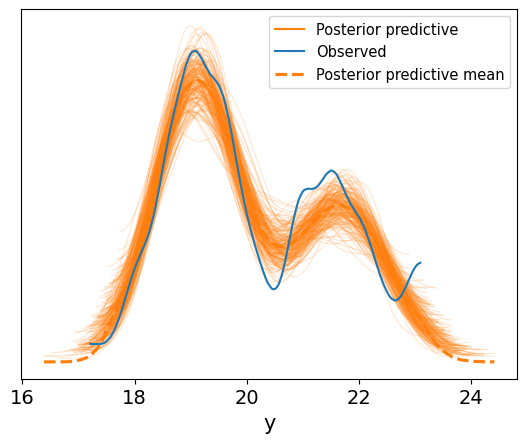

In [12]:
pm.sample_posterior_predictive(idata_nh, model=nh_model,  extend_inferencedata=True)
az.plot_ppc(idata_nh, num_pp_samples=200, colors=["C1", "C0", "C1"])

The posterior predictive to observed check is remarkably good, considering I didn't use any outside functions (like exp, log, sqrt, etc.). The **left tail** is very well matched and **each peak** is accounted (though the lower one seems to have room for improvement). The **rightwards tail** ends a bit abruptly, but overall, this model seems to do a pretty good job.

# **Part 4: Linear Model (Whole Data)**

Let's also try doing a linear model with the **entire dataset at once** (not separated by species).

In [13]:
with pm.Model() as model_whole:
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    μ = pm.Deterministic("μ", α + β * penguins["body_mass"])
    σ = pm.HalfCauchy("σ", 10)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=penguins['flipper_length'])

    idata_whole = pm.sample()

Output()

Output()

In [14]:
pm.sample_posterior_predictive(idata_whole, model=model_whole,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Flipper Length')

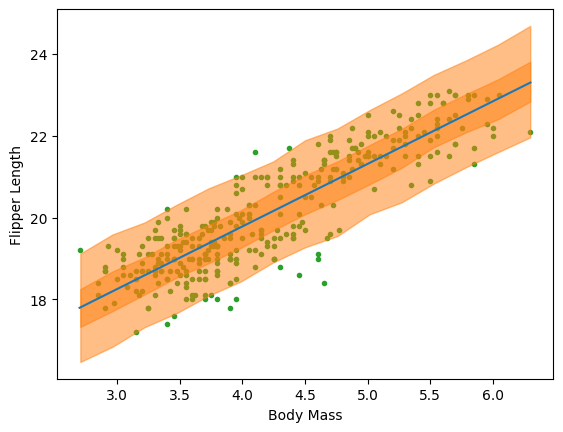

In [15]:
#grabs the expected line, or line of best fit formula
mean_line = idata_whole.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
masses = np.random.normal(penguins["body_mass"].values, 0.01)
idx = np.argsort(masses)
x = np.linspace(masses.min(), masses.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_whole.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(masses[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(penguins["body_mass"], penguins["flipper_length"], "C2.", zorder=-3)
ax.plot(penguins["body_mass"][idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for whole, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, whole, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Body Mass")
ax.set_ylabel("Flipper Length")

Output()

<Axes: xlabel='y_pred'>

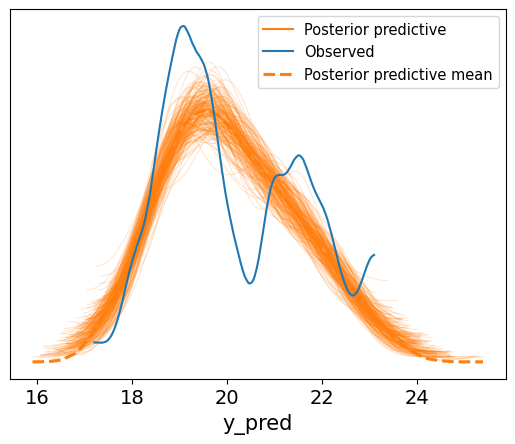

In [16]:
pm.sample_posterior_predictive(idata_whole, model=model_whole,  extend_inferencedata=True)
az.plot_ppc(idata_whole, num_pp_samples=200, colors=["C1", "C0", "C1"])

Well, it's safe to say this model doesn't too well modeling the entire dataset. It matches a general trend of up then down, but the observed has three distinct peaks which are **impossible** to model accurately without **grouping**.